# Assignment 3: Classification with Logistic Regression

## Instructions

* Complete the assignment as outlined below.
* Restart your kernel and rerun your cells before submission.
* Submit your completed notebook (.ipynb).

## Dataset Information

The dataset contains health-related data for predicting diabetes. Below are the features:

* `Pregnancies`: Number of pregnancies
* `Glucose`: Plasma glucose concentration
* `BloodPressure`: Diastolic blood pressure (mm Hg)
* `SkinThickness`: Triceps skin fold thickness (mm)
* `Insulin`: 2-hour serum insulin (mu U/ml)
* `BMI`: Body mass index
* `DiabetesPedigreeFunction`: Diabetes pedigree function
* `Age`: Age (years)
* `Outcome`: Target variable (1 = Diabetes, 0 = No Diabetes)

Your goal in this homework is to train a first model for predicting the probability that a patient has diabetes given their healthcare data.

In [ ]:
# Suggested packages, you can add more if you think they are necessary.
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
# Download the data. Uncomment if using Colab.
!gdown https://drive.google.com/uc?id=1-_YcEl0q5LsDXRq5eix9K4gjSq78Ffd5

Downloading...
From: https://drive.google.com/uc?id=1-_YcEl0q5LsDXRq5eix9K4gjSq78Ffd5
To: /content/diabetes.csv
100% 23.1k/23.1k [00:00<00:00, 48.1MB/s]


## Question 1:

1. Load the dataset `diabetes.csv` and display the first 5 rows.
2. Print out all columns in the dataset and identify any missing values.
3. Show the descriptive statistics of the data.

In [ ]:
# Load the dataset
data = pd.read_csv('diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
# Report number of null values
data.isnull().any()

,0
Pregnancies,False
Glucose,False
BloodPressure,False
SkinThickness,False
Insulin,False
BMI,False
DiabetesPedigreeFunction,False
Age,False
Outcome,False


By first glance, the data does not have any NaN values. However, we should also check the existence of null values by the code below.

In [ ]:
# Show descriptive statistics
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


From the output, we can find that the columns: `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, `BMI` have minimum values of 0. However, in reality, their values should not be 0. Therefore, they are likely to be the null values.

In [ ]:
# In reality, the column below should not have values == 0
non_zero_col = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
zero_row = (data[non_zero_col] == 0).any(axis=1)
data[zero_row]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
5,5,116,74,0,0,25.6,0.201,30,0
7,10,115,0,0,0,35.3,0.134,29,0
...,...,...,...,...,...,...,...,...,...
761,9,170,74,31,0,44.0,0.403,43,1
762,9,89,62,0,0,22.5,0.142,33,0
764,2,122,70,27,0,36.8,0.340,27,0
766,1,126,60,0,0,30.1,0.349,47,1


In [ ]:
(data[non_zero_col] == 0).sum()

,0
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11


In [ ]:
((data[non_zero_col] == 0).sum()).sum()

652

There are 376 rows with null values, with 652 null values in total.

Number of null values: 652

Then, we replace the null values with the column median.

In [ ]:
for col in non_zero_col:
    # Median excluding zeros
    median = data.loc[data[col] != 0, col].median()
    print(f"Median of '{col}' (excluding zeros): {median}")
    data.loc[data[col] == 0, col] = median

Median of 'Glucose' (excluding zeros): 117.0
Median of 'BloodPressure' (excluding zeros): 72.0
Median of 'SkinThickness' (excluding zeros): 29.0
Median of 'Insulin' (excluding zeros): 125.0
Median of 'BMI' (excluding zeros): 32.3


In [ ]:
# Show descriptive statistics
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,29.108073,140.671875,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,8.791221,86.383060,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## Question 2:

What is the baseline accuracy for this classification problem? Baseline accuracy is the accuracy of always predicting the most common class. You can assume there are no outliers in the data.

In [ ]:
# Question 2 code
most_commmon_class_count = data['Outcome'].value_counts().max()
data['Outcome'].value_counts()

,count
Outcome,
0,500
1,268


In [ ]:
print(f"The number of data in the most common class is {most_commmon_class_count}.")

The number of data in the most common class is 500.


In [ ]:
baselineacc = most_commmon_class_count / len(data)
print(f"The baseline accuracy of the problem is {baselineacc*100:.2f}%")

The baseline accuracy of the problem is 65.10%


## Question 3:

Split the data into training and testing sets. Use 70% of the data for training and 30% for testing. Pass `random_state = 42` to `train_test_split`. Ensure the `Outcome` column is the response variable. Report the descriptive statistics of X_train and X_test.

In [ ]:
# Question 3 code
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['Outcome']), data['Outcome'], test_size=0.3, random_state=42, stratify=data['Outcome'])

In [ ]:
# Display the descriptive statistics of X_train
X_train.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000
mean,3.882682,121.564246,72.227188,28.886406,138.057728,32.615829,0.480529,33.551210
std,3.350097,29.951703,12.186692,8.259105,79.727535,6.730690,0.335253,11.794639
min,0.000000,57.000000,24.000000,7.000000,16.000000,18.200000,0.084000,21.000000
25%,1.000000,99.000000,64.000000,25.000000,122.000000,27.800000,0.246000,24.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.400000,0.385000,30.000000
75%,6.000000,141.000000,80.000000,32.000000,130.000000,36.400000,0.645000,41.000000
max,17.000000,198.000000,122.000000,60.000000,744.000000,67.100000,2.329000,81.000000


In [ ]:
# Display the descriptive statistics of X_test
X_test.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000
mean,3.757576,121.870130,72.757576,29.623377,146.748918,32.081818,0.451762,32.519481
std,3.420160,31.605868,11.902580,9.918852,100.089209,7.201016,0.321835,11.673393
min,0.000000,44.000000,44.000000,10.000000,14.000000,18.200000,0.078000,21.000000
25%,1.000000,100.000000,66.000000,24.000000,122.500000,26.250000,0.237000,23.000000
50%,3.000000,118.000000,72.000000,29.000000,125.000000,32.000000,0.342000,28.000000
75%,6.000000,139.500000,79.000000,33.000000,125.000000,36.700000,0.599000,38.500000
max,15.000000,199.000000,110.000000,99.000000,846.000000,59.400000,2.420000,69.000000


**Written question: Are the descriptive statistics of the X_train and X_test datasets similar? Is this a reasonable dataset for the problem?**

**Written answer:**

The descriptive statistics for `X_train` and `X_test` are  similar in terms of mean, standard deviation, and distribution of values for each feature.

However, the dataset has potential problems that variability exists within the predictors: especially for `Insulin` with relatively high values and `DiabetesPedigreeFunction` with relatively low values. Therefore, standardization is needed to further develop the model.

## Question 4:

1. Create a pipeline that first standardizes the data using a z-scale transform, and then trains an instance of `LogisticRegression` with `penalty = None` and `max_iter = 1000`. Use the same random seed you used before.
2. Train the pipeline using the training set.

In [ ]:
# Question 4 code
# Create a pipeline that scales the features and trains a logistic regression model

# Define the features to transform
features_to_transform = data.columns.tolist()
features_to_transform = features_to_transform[0:8]

# Create a ColumnTransformer object that scales the features to transform
transform_numbers = ColumnTransformer(
    [('scaler', StandardScaler(), features_to_transform)],
    remainder='passthrough',  # Keep other columns as is (if any)
    verbose_feature_names_out=False
)

# Train the pipeline
logit_pipe = Pipeline([
    ('scaler', transform_numbers),
    ('logistic_regression', LogisticRegression(
        solver='lbfgs',
        penalty=None,
        max_iter=1000,
        verbose=1,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    ))
])

logit_pipe.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['Pregnancies', 'Glucose',
                                                   'BloodPressure',
                                                   'SkinThickness', 'Insulin',
                                                   'BMI',
                                                   'DiabetesPedigreeFunction',
                                                   'Age'])],
                                   verbose_feature_names_out=False)),
                ('logistic_regression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    n_jobs=-1, penalty=None, random_state=42,
                                    verbose=1))])

## Question 5:

1. Compute the model’s accuracy on the training and testing sets.
2. Display the model’s coefficients and intercept.

In [ ]:
# Display coefficients
# Get the training parameters in a dataframe with the corresponding feature names
training_params = pd.DataFrame(logit_pipe.named_steps['logistic_regression'].coef_, columns=X_train.columns)

# Get the intercept of the logistic regression model
training_params['intercept'] = logit_pipe.named_steps['logistic_regression'].intercept_
training_params

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,intercept
0,0.4735,1.156636,-0.022251,-0.119962,-0.033613,0.780925,0.273168,0.132503,-0.246915


In [ ]:
print(classification_report(y_test, logit_pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.79      0.82       150
           1       0.65      0.72      0.68        81

    accuracy                           0.77       231
   macro avg       0.74      0.75      0.75       231
weighted avg       0.77      0.77      0.77       231



In [ ]:
# Compute accuracy on the training set
train_accuracy = logit_pipe.score(X_train, y_train)
print(f"The model’s accuracy on the training set is {train_accuracy*100:.2f}%")

# Compute accuracy on the testing set
test_accuracy = logit_pipe.score(X_test, y_test)
print(f"The model’s accuracy on the testing set is {test_accuracy*100:.2f}%")

The model’s accuracy on the training set is 77.47%
The model’s accuracy on the testing set is 76.62%


## Question 6:

1. Plot the ROC curve for the logistic regression model using the testing set. Make sure your plot includes a title and properly labeled axes.
2. Compute the area under the curve (AUC). Report the AUC at the top-left of your plot.

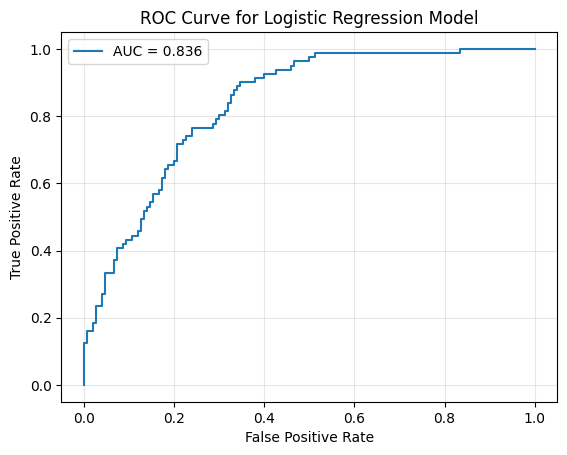

In [ ]:
# Question 6 code
ytest_pred = logit_pipe.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=ytest_pred[:,1])
auc = np.round(roc_auc_score(y_true=y_test, y_score=ytest_pred[:,1]), decimals = 3)

# Plot ROC curve
plt.plot(fpr,tpr,label=f"AUC = {auc:.3f}")
plt.legend(loc=2)
plt.title('ROC Curve for Logistic Regression Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(alpha=0.3)
plt.show()

**Written question: Comment on the capacity of the model to predict the outcome. Is the AUC acceptable?**

**Written answer:**

Since the AUC value is larger than $0.5$, which means the performance of the model is better than random guessing. So, it is an acceptance AUC and the model is good for predicting diabetes.